In [1]:
from assetreturns import generateLeaseholdPropertyForecast, mortgageFactory, TaxDeductibleMortgage, RepaymentMortgage, InterestOnlyMortgage, HLStock, calculateSDLT, LeaseholdProperty
import pandas as pd
import numpy as np
from tabulate import tabulate
import altair as alt

if __name__ == "__main__":
    ltv_percentage = 0.75
    interest_rate = 0.0259
    #interest_rate = 0.05
    #interest_rate = 0.0146
    asset_dictionary = {}

    #asset_dictionary["BRK.B 21 P/E"] = HLStock(250000, 21.73)
    

    #     asset_dictionary["BRK.B 15 P/E"] = HLStock(150000, 15)

    #     asset_dictionary["BRK.B 10 P/E"] = HLStock(150000, 10)

    #     # asset_dictionary["BRK.B 7 P/E"] = HLStock(200000, 7)

    #     property_forecast = generatePropertyForecast(True, 100000, ltv_percentage=ltv_percentage, monthly_gross_rental=750, rental_tax=0.45,
    #                                                  months_occupied_out_of_12=10,
    #                                                  agency_percentage=.2, MortgageClass=TaxDeductibleMortgage,
    #                                                  MortgageClassToDecorate=RepaymentMortgage, tax_rate=0.2, length=25,
    #                                                  interest_rate=0.03)
    #     #asset_dictionary["High Yield Property"] = property_forecast

    #     property_forecast = generatePropertyForecast(True, 220000, ltv_percentage=ltv_percentage, monthly_gross_rental=800, rental_tax=0.45,
    #                                                  months_occupied_out_of_12=10,
    #                                                  agency_percentage=.2, MortgageClass=TaxDeductibleMortgage,
    #                                                  MortgageClassToDecorate=RepaymentMortgage, tax_rate=0.2, length=25,
    #                                                  interest_rate=0.03)
    #     #asset_dictionary["Albany Gardens, Hythe"] = property_forecast

    #     property_forecast = generatePropertyForecast(True, 220000, ltv_percentage=ltv_percentage, monthly_gross_rental=800, rental_tax=0.2,
    #                                                  months_occupied_out_of_12=10,
    #                                                  agency_percentage=.2, MortgageClass=TaxDeductibleMortgage,
    #                                                  MortgageClassToDecorate=RepaymentMortgage, tax_rate=0.2, length=25,
    #                                                  interest_rate=0.03)
    #     #asset_dictionary["Albany Gardens, Hythe, Non Resident"] = property_forecast

    #     property_forecast = generatePropertyForecast(True, 100000, ltv_percentage=ltv_percentage, monthly_gross_rental=750, rental_tax=0.45,
    #                                                  months_occupied_out_of_12=10,
    #                                                  agency_percentage=.2, MortgageClass=TaxDeductibleMortgage,
    #                                                  MortgageClassToDecorate=RepaymentMortgage, tax_rate=0.2, length=25,
    #                                                  interest_rate=0.10)
    #     asset_dictionary["10% Interest World Property"] = property_forecast

    property_forecast = generateLeaseholdPropertyForecast(True, 750000, ltv_percentage=ltv_percentage,
                                                          monthly_gross_rental=(700 + 700 * 3), rental_tax=0.45,
                                                          months_occupied_out_of_12=10,
                                                          agency_percentage=.2, annual_service_charge=1500,
                                                          annual_ground_rent=90, mortgage_searcher=mortgageFactory,
                                                          MortgageClass=TaxDeductibleMortgage,
                                                          MortgageClassToDecorate=RepaymentMortgage, tax_rate=0.2,
                                                          length=25,
                                                          interest_rate=0.0259)

    asset_dictionary["Cookham House"] = property_forecast

    #     property_forecast = generateLiveInLandlordPropertyForecast(False, 525000, 0.8, monthly_gross_rental=(500 + 100 * 2),
    #                                                                rental_tax=0.45,
    #                                                                months_occupied_out_of_12=10,
    #                                                                agency_percentage=.2,
    #                                                                MortgageClass=TaxDeductibleMortgage,
    #                                                                MortgageClassToDecorate=RepaymentMortgage, tax_rate=0.2,
    #                                                                length=25,
    #                                                                interest_rate=0.0259)
    #     #asset_dictionary["Grandby House"] = property_forecast

    lixing_agency_percentage = (0.075 + 0.025) * 1.20
    asset_dictionary["2 Bed 1 bath long and waterson"] = generateLeaseholdPropertyForecast(True, 690000,
                                                                                           ltv_percentage=ltv_percentage,
                                                                                           #monthly_gross_rental=700 * 4.3,
                                                                                           monthly_gross_rental=625,
                                                                                           rental_tax=0,
                                                                                           months_occupied_out_of_12=12,
                                                                                           agency_percentage=lixing_agency_percentage,
                                                                                           annual_service_charge=7 * 677,
                                                                                           annual_ground_rent=600,
                                                                                           mortgage_searcher=mortgageFactory,
                                                                                           MortgageClass=RepaymentMortgage,
                                                                                           length=25,
                                                                                           interest_rate=interest_rate)

    #     asset_dictionary["3 Bed 2 bath long and waterson"] = generateLeaseholdPropertyForecast(True, 1180000, ltv_percentage=ltv_percentage, monthly_gross_rental=1100*4.3, rental_tax=0.45,
    #                                                  months_occupied_out_of_12=10,
    #                                                  agency_percentage=.2, annual_service_charge=7*1264, annual_ground_rent=600, MortgageClass=TaxDeductibleMortgage,
    #                                                  MortgageClassToDecorate=RepaymentMortgage, tax_rate=0.2, length=25,
    #                                                  interest_rate=0.0259)

    atlas_price = 980000
    #atlas_price = 900000

    # Recently sold for this price.
    heron_property_price = 535000
    heron_property_price = 600000
    asset_dictionary["Heron - Studio"] = generateLeaseholdPropertyForecast(True, heron_property_price,
                                                                                   ltv_percentage=ltv_percentage,
                                                                                   #monthly_gross_rental=3467,
                                                                                   monthly_gross_rental=0,
                                                                                   rental_tax=0,
                                                                                   months_occupied_out_of_12=10,
                                                                                   agency_percentage=0,
                                                                                   annual_service_charge=3967,
                                                                                   annual_ground_rent=300,
                                                                                   mortgage_searcher=mortgageFactory,
                                                                                   MortgageClass=RepaymentMortgage,
                                                                                   length=25,
                                                                                   interest_rate=interest_rate)
    
    
    #asset_dictionary["BRK.B 40 P/E"] = HLStock(250000, 40, yearly_principle_repayment-2535*12)
    #asset_dictionary["BRK.B 40 P/E"] = HLStock(535000*.25, 40, yearly_principle_repayment-2535*12)
    
    def generateHeaderTableAndGraphSource():

        headers = ["Asset Name", "Initial Equity Cost", "Nominal ROI", "% ROI", "% ROI Year on Year", "Nominal Profit"]
        table = []

        years_to_forecast = 50
        graph_source = pd.DataFrame(index=np.arange(0, years_to_forecast * len(asset_dictionary)),
                                    columns=["Asset Name", "Year", "Nominal ROI", "% ROI Year on Year", "% ROI", "Nominal Profit"])
        inflation_rate = 0.01
        j = 0
        for key, value in asset_dictionary.items():

            for i in range(0, years_to_forecast):
                years = i + 1
                # graph_source.loc[i] = [[key, value.initial_equity_cost + value.nominal_return_on_investment(years, 0, 0), value.percentage_return_on_investment(years, 0, 0), value.annual_percentage_return_on_investment(years, 0, 0)]]
                if years == 1:
                    roi_this_year = value.percentage_return_on_investment(years, inflation_rate, 0)
                    profit_this_year = value.calculate_profits(years)
                else:
                    roi_this_year = value.percentage_return_on_investment(years, inflation_rate,
                                                                          0) - value.percentage_return_on_investment(
                        years - 1, inflation_rate, 0)
                    profit_this_year = value.calculate_profits(years)-value.calculate_profits(years-1)
                graph_source.loc[j + i] = [key, years,
                                           value.nominal_return_on_investment(years, inflation_rate, 0),
                                           value.annual_percentage_return_on_investment(years, inflation_rate, 0),
                                           roi_this_year, profit_this_year]
                row = [key, value.initial_equity_cost, value.nominal_return_on_investment(25, 0, 0), 
                   value.percentage_return_on_investment(25, 0.01, 0),
                   value.annual_percentage_return_on_investment(25, inflation_rate, 0), profit_this_year]
            table.append(row)
                # print(f"{key} {years} {value.initial_equity_cost + value.nominal_return_on_investment(years, 0, 0)}")
            j += years_to_forecast
        return headers, table, graph_source
    (headers, table, graph_source) = generateHeaderTableAndGraphSource()
    print(tabulate(table, headers, tablefmt="presto"))
    alt.renderers.enable('html')

stock_price_to_earnings = 35
#stock_price_to_earnings = 80
cost_of_renting_alone = 2535
cost_of_renting_alone = 2250
cost_of_renting_alone = 1842
cost_of_renting_alone = 2000
cost_of_renting_alone = 2600
cost_of_renting_alone = 2700
atlas_fully_rented_out = 3467
atlas_fully_rented_out = 3067
atlas_studio_property_price = 550000
del asset_dictionary["2 Bed 1 bath long and waterson"]
del asset_dictionary["Cookham House"]
del asset_dictionary["Heron - Studio"]

# TODO model typical stocks, BRK.A / Index funds?
# TODO would be nice to know what what interest rate a given property becomes not worth it.
# Double check profit and loss maths are correct
# alt.Chart(graph_source).mark_line().encode(x='Year', y='Nominal ROI', color='Asset Name', strokeDash='Asset Name').properties(width=700, height=700)
# alt.Chart(graph_source[graph_source["Asset Name"] == "10% Interest World Property"]).mark_line().encode(x='Year', y='Nominal ROI', color='Asset Name', strokeDash='Asset Name')

 Asset Name                     |   Initial Equity Cost |   Nominal ROI |   % ROI |   % ROI Year on Year |   Nominal Profit
--------------------------------+-----------------------+---------------+---------+----------------------+------------------
 Cookham House                  |                187500 |        587431 | 3.96473 |            0.066193  |             9800
 2 Bed 1 bath long and waterson |                172501 |        439526 | 3.38133 |            0.060875  |             6600
 Heron - Studio                 |                150001 |        239253 | 2.43138 |            0.0505548 |                0


In [2]:
# Calculate how much someone could save over X months.
# Example 
months_employed = 60
initial_balance = 50000
net_monthly_salary = 7000
bonus_month = 12
net_yearly_bonus = 10000
monthly_cost_of_living = 4000

employment_income = pd.DataFrame(index=np.arange(0, months_employed),
                                          columns=["Net Income", "Balance"])
employment_income["Net Income"].values[:] = 0
employment_income["Balance"].values[:] = 0

first_row = employment_income.loc[0]
first_row["Net Income"] = net_monthly_salary - monthly_cost_of_living
first_row["Balance"] = initial_balance+first_row["Net Income"]

for i in range(1, months_employed):
    row = employment_income.loc[i]
    row["Net Income"] = net_monthly_salary - monthly_cost_of_living
    if (i+1) % bonus_month == 0:
        row["Net Income"] += net_yearly_bonus
    
    previous_balance = employment_income.loc[i-1]["Balance"]
    row["Balance"] = previous_balance+row["Net Income"]
print(employment_income.tail(3))

fixed_interest_rate = 0.02
fixed_interest_rate = 0.0319
repayment_mortgage =  RepaymentMortgage(540000, 25, fixed_interest_rate,
                             {1 * 12: 0.1, 2 * 12: 0.1, 3 * 12: 0.1, 4 * 12: 0.1, 5 * 12: 1})
print(repayment_mortgage.total_payments(25)/0.75)

# Max leverage for 5 year mortgage with bonuses.
# 506/0.75=674

   Net Income Balance
57       3000  264000
58       3000  267000
59      13000  280000
805221.4665807177


[np.float64(17053.407911412916), np.float64(-14802.588376213022), np.float64(-14241.230945414325), np.float64(-13661.966212573047), np.float64(-13064.222934754172), np.float64(-12447.411646372813), np.float64(-11810.924077892123), np.float64(-11154.13255597654), np.float64(-10476.389384512207), np.float64(-9777.026205878123), np.float64(-9055.35334184562), np.float64(-8310.6591134505), np.float64(-7542.209139169601), np.float64(-6749.245610709069), np.float64(-5930.986545691267), np.float64(-5086.625016498903), np.float64(-4215.328354525263), np.float64(-3316.2373290346586), np.float64(-2388.465299830772), np.float64(-1431.097342895344), np.float64(-443.18934813374653), np.float64(576.2329116608016), np.float64(1628.1747415427817), np.float64(2713.6735157980584)]


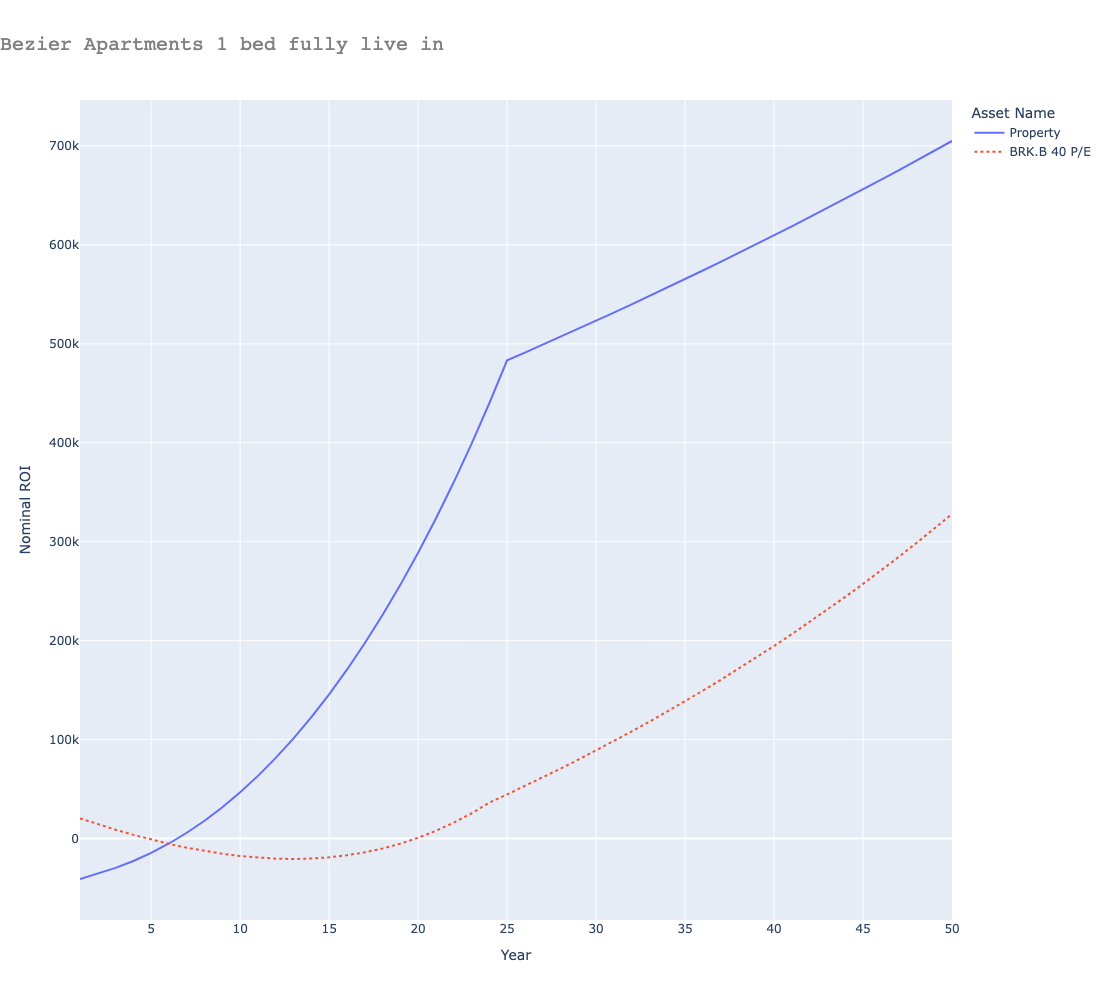

In [3]:
# Even here I'd have to live in the property for 4 years for buying it to make sense vs renting it
property_price = 850000
#repayment_mortgage =  RepaymentMortgage(850000*0.75, 25, fixed_interest_rate,
#                             {1 * 12: 0.1, 2 * 12: 0.1, 3 * 12: 0.1, 4 * 12: 0.1, 5 * 12: 1})
repayment_mortgage =  RepaymentMortgage(property_price*0.75, 25, fixed_interest_rate)
asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(False, property_price,
                                                  monthly_gross_rental=0,
                                                  rental_tax=0,
                                                  months_occupied_out_of_12=8,
                                                  agency_percentage=lixing_agency_percentage,
                                                  annual_service_charge=7 * 677,
                                                  annual_ground_rent=600,
                                                  mortgage = repayment_mortgage)
opportunity_cost_property = asset_dictionary[asset_name]
#opportunity_cost_property.will_you_live_in_this = False
yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)
for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year - cost_of_renting_alone*12)
    previous_year = current_year
#print(repayment_mortgage.payment_table)
print(yearly_principle_repayments)
asset_dictionary["BRK.B 40 P/E"] = HLStock(opportunity_cost_property.property_value*.25, stock_price_to_earnings, yearly_principle_repayments)
(headers, table, graph_source) = generateHeaderTableAndGraphSource()

import plotly.express as px

fig = px.line(graph_source, 
              x='Year', 
              y='Nominal ROI', 
              color='Asset Name',
              line_dash='Asset Name',
              title='Bezier Apartments 1 bed fully live in',
              width=1000,
              height=1000)

fig.update_layout(
    title_font_size=20,
    title_font_family='Courier',
    title_font_color='gray',
    title_x=0  # anchor='start' equivalent
)

fig.show()

In [4]:
property_price = 1050000
#repayment_mortgage =  RepaymentMortgage(850000*0.75, 25, fixed_interest_rate,
#                             {1 * 12: 0.1, 2 * 12: 0.1, 3 * 12: 0.1, 4 * 12: 0.1, 5 * 12: 1})

repayment_mortgage =  RepaymentMortgage(property_price*0.75, 25, fixed_interest_rate)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(False, property_price,
                                                                                       monthly_gross_rental=0,
                                                                                       rental_tax=0,
                                                                                       months_occupied_out_of_12=8,
                                                                                       agency_percentage=lixing_agency_percentage,
                                                                                       annual_service_charge=7 * 677,
                                                                                       annual_ground_rent=600,
                                                                                       mortgage = repayment_mortgage)
opportunity_cost_property = asset_dictionary[asset_name]
#opportunity_cost_property.will_you_live_in_this = False

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)
for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year - cost_of_renting_alone*12)
    previous_year = current_year
#print(repayment_mortgage.payment_table)
print(yearly_principle_repayments)
asset_dictionary["BRK.B 40 P/E"] = HLStock(opportunity_cost_property.property_value*.25, stock_price_to_earnings, yearly_principle_repayments)
(headers, table, graph_source) = generateHeaderTableAndGraphSource()
alt.Chart(graph_source).mark_line().encode(x='Year', y='Nominal ROI', color='Asset Name', strokeDash='Asset Name'
    ).properties(width=1000, height=1000, title=f'Eagle Point 15th Floor 2 bed live in'
    ).configure_title(fontSize=20, font='Courier', anchor='start', color='gray')

[np.float64(21065.974478804204), np.float64(-10662.02093532195), np.float64(-9968.57940315875), np.float64(-9253.017086119507), np.float64(-8514.628331166692), np.float64(-7752.684974930875), np.float64(-6966.4356256311585), np.float64(-6155.104922088794), np.float64(-5317.892769103404), np.float64(-4453.973548437731), np.float64(-3562.495304632961), np.float64(-2642.5789048504084), np.float64(-1693.3171719147358), np.float64(-713.7739896987914), np.float64(297.01662002975354), np.float64(1340.0514502086444), np.float64(2416.359091470251), np.float64(3527.000946488115), np.float64(4673.0722766810795), np.float64(5855.703282307368), np.float64(7076.060217012768), np.float64(8335.346537935431), np.float64(9634.804092495702), np.float64(10975.714343046304)]


alt.Chart(...)

In [5]:
# Even here I'd have to live in the property for 4 years for buying it to make sense vs renting it
property_price = 1050000
#repayment_mortgage =  RepaymentMortgage(850000*0.75, 25, fixed_interest_rate,
#                             {1 * 12: 0.1, 2 * 12: 0.1, 3 * 12: 0.1, 4 * 12: 0.1, 5 * 12: 1})

repayment_mortgage =  RepaymentMortgage(property_price*0.75, 25, fixed_interest_rate)
length  = 25
#repayment_mortgage =  InterestOnlyMortgage(property_price*0.75, length, fixed_interest_rate)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(False, property_price,
                                                                                       monthly_gross_rental=7200/12,
                                                                                       rental_tax=0,
                                                                                       months_occupied_out_of_12=8,
                                                                                       agency_percentage=lixing_agency_percentage,
                                                                                       annual_service_charge=7 * 677,
                                                                                       annual_ground_rent=600,
                                                                                       mortgage = repayment_mortgage)
opportunity_cost_property = asset_dictionary[asset_name]
#opportunity_cost_property.will_you_live_in_this = False

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)
for year in range(2, length):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year - cost_of_renting_alone*12)
    previous_year = current_year
#print(repayment_mortgage.payment_table)
#print(yearly_principle_repayments)
asset_dictionary["BRK.B 40 P/E"] = HLStock(opportunity_cost_property.property_value*.25, stock_price_to_earnings, yearly_principle_repayments)
(headers, table, graph_source) = generateHeaderTableAndGraphSource()
alt.Chart(graph_source).mark_line().encode(x='Year', y='Nominal ROI', color='Asset Name', strokeDash='Asset Name'
    ).properties(width=1000, height=1000, title=f'Eagle Point 15th Floor 2 bed live in + rent out 1 room'
    ).configure_title(fontSize=20, font='Courier', anchor='start', color='gray')

#opportunity_table = graph_source.pivot(index="Year", columns="Asset Name", values="Nominal Profit")
#opportunity_table["Property - BRK"] = opportunity_table["Property"] - opportunity_table["BRK.B 40 P/E"]
#opportunity_table["Loss buffer"] = opportunity_table["Property - BRK"] / (property_price + opportunity_cost_property.buy_expenses)
#print(opportunity_table)

alt.Chart(...)

In [6]:
# Even here I'd have to live in the property for 4 years for buying it to make sense vs renting it
property_price = 1050000
#repayment_mortgage =  RepaymentMortgage(850000*0.75, 25, fixed_interest_rate,
#                             {1 * 12: 0.1, 2 * 12: 0.1, 3 * 12: 0.1, 4 * 12: 0.1, 5 * 12: 1})

repayment_mortgage =  RepaymentMortgage(property_price*0.85, 25, fixed_interest_rate)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(False, property_price,
                                                                                       monthly_gross_rental=3300,
                                                                                       rental_tax=0.45,
                                                                                       months_occupied_out_of_12=8,
                                                                                       agency_percentage=lixing_agency_percentage,
                                                                                       annual_service_charge=7 * 456,
                                                                                       annual_ground_rent=600,
                                                                                       mortgage = repayment_mortgage)
opportunity_cost_property = asset_dictionary[asset_name]
opportunity_cost_property.will_you_live_in_this = False

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)
for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year)
    previous_year = current_year
#print(repayment_mortgage.payment_table)
print(yearly_principle_repayments)
asset_dictionary["BRK.B 40 P/E"] = HLStock(opportunity_cost_property.property_value*.25, stock_price_to_earnings, yearly_principle_repayments)
(headers, table, graph_source) = generateHeaderTableAndGraphSource()
alt.Chart(graph_source).mark_line().encode(x='Year', y='Nominal ROI', color='Asset Name', strokeDash='Asset Name'
    ).properties(width=1000, height=1000, title=f'Eagle Point 15th Floor 2 bed fully let out'
    ).configure_title(fontSize=20, font='Courier', anchor='start', color='gray')

[np.float64(23874.771075978086), np.float64(24636.376273301812), np.float64(25422.27667642008), np.float64(26233.247302397795), np.float64(27070.087891344287), np.float64(27933.62369507854), np.float64(28824.706290951523), np.float64(29744.214421632932), np.float64(30693.05486168299), np.float64(31672.163311770622), np.float64(32682.50532141619), np.float64(33725.07724116923), np.float64(34800.907205162686), np.float64(35911.05614500737), np.float64(37056.6188360331), np.float64(38238.72497690254), np.float64(39458.54030366562), np.float64(40717.26773935277), np.float64(42016.14858023799), np.float64(43356.46371994761), np.float64(44739.53491261287), np.float64(46166.72607632482), np.float64(47639.44463815971), np.float64(49159.14292211691)]


alt.Chart(...)

In [7]:
# Even here I'd have to live in the property for 4 years for buying it to make sense vs renting it
property_price = 685000
#repayment_mortgage =  RepaymentMortgage(850000*0.75, 25, fixed_interest_rate,
#                             {1 * 12: 0.1, 2 * 12: 0.1, 3 * 12: 0.1, 4 * 12: 0.1, 5 * 12: 1})

repayment_mortgage =  RepaymentMortgage(property_price*0.85, 25, fixed_interest_rate)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(False, property_price,
                                                                                       monthly_gross_rental=0,
                                                                                       rental_tax=0,
                                                                                       months_occupied_out_of_12=8,
                                                                                       agency_percentage=lixing_agency_percentage,
                                                                                       annual_service_charge=7 * 603,
                                                                                       annual_ground_rent=600,
                                                                                       mortgage = repayment_mortgage)
opportunity_cost_property = asset_dictionary[asset_name]
#opportunity_cost_property.will_you_live_in_this = False
cost_of_renting_alone = 2600
yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)
for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year - cost_of_renting_alone*12)
    previous_year = current_year
#print(repayment_mortgage.payment_table)
print(yearly_principle_repayments)
asset_dictionary["BRK.B 40 P/E"] = HLStock(opportunity_cost_property.property_value*.25, stock_price_to_earnings, yearly_principle_repayments)
(headers, table, graph_source) = generateHeaderTableAndGraphSource()
alt.Chart(graph_source).mark_line().encode(x='Year', y='Nominal ROI', color='Asset Name', strokeDash='Asset Name'
    ).properties(width=1000, height=1000, title=f'Eagle Point 15th Floor 1 bed live in'
    ).configure_title(fontSize=20, font='Courier', anchor='start', color='gray')

[np.float64(15575.445892423788), np.float64(-15127.697383607872), np.float64(-14614.990930144973), np.float64(-14085.92914081661), np.float64(-13539.99028040866), np.float64(-12976.635970353731), np.float64(-12395.310657808048), np.float64(-11795.441067792184), np.float64(-11176.435637855), np.float64(-10537.683934702567), np.float64(-9878.556052219647), np.float64(-9198.401990285405), np.float64(-8496.55101377549), np.float64(-7772.310991114937), np.float64(-7024.967711731559), np.float64(-6253.784181735828), np.float64(-5457.99989713321), np.float64(-4636.83009385172), np.float64(-3789.4649738455773), np.float64(-2915.0689065112383), np.float64(-2012.7796046289732), np.float64(-1081.707274016575), np.float64(-120.93373605771922), np.float64(870.48847776209)]


alt.Chart(...)

In [8]:
# Even here I'd have to live in the property for 4 years for buying it to make sense vs renting it
property_price = 685000
#repayment_mortgage =  RepaymentMortgage(850000*0.75, 25, fixed_interest_rate,
#                             {1 * 12: 0.1, 2 * 12: 0.1, 3 * 12: 0.1, 4 * 12: 0.1, 5 * 12: 1})

repayment_mortgage =  RepaymentMortgage(property_price*0.85, 25, fixed_interest_rate)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(False, property_price,
                                                                                       monthly_gross_rental=2600,
                                                                                       rental_tax=0.45,
                                                                                       months_occupied_out_of_12=8,
                                                                                       agency_percentage=lixing_agency_percentage,
                                                                                       annual_service_charge=7 * 603,
                                                                                       annual_ground_rent=600,
                                                                                       mortgage = repayment_mortgage)
opportunity_cost_property = asset_dictionary[asset_name]
opportunity_cost_property.will_you_live_in_this = False
yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)
for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year)
    previous_year = current_year
#print(repayment_mortgage.payment_table)
print(yearly_principle_repayments)
asset_dictionary["BRK.B 40 P/E"] = HLStock(opportunity_cost_property.property_value*.25, stock_price_to_earnings, yearly_principle_repayments)
(headers, table, graph_source) = generateHeaderTableAndGraphSource()
alt.Chart(graph_source).mark_line().encode(x='Year', y='Nominal ROI', color='Asset Name', strokeDash='Asset Name'
    ).properties(width=1000, height=1000, title=f'Eagle Point 15th Floor 1 bed fully let out'
    ).configure_title(fontSize=20, font='Courier', anchor='start', color='gray')

[np.float64(15575.445892423788), np.float64(16072.302616392128), np.float64(16585.009069855027), np.float64(17114.07085918339), np.float64(17660.00971959134), np.float64(18223.36402964627), np.float64(18804.689342191952), np.float64(19404.558932207816), np.float64(20023.564362145), np.float64(20662.316065297433), np.float64(21321.443947780353), np.float64(22001.598009714595), np.float64(22703.44898622451), np.float64(23427.689008885063), np.float64(24175.03228826844), np.float64(24946.215818264172), np.float64(25742.00010286679), np.float64(26563.16990614828), np.float64(27410.535026154423), np.float64(28284.93109348876), np.float64(29187.220395371027), np.float64(30118.292725983425), np.float64(31079.06626394228), np.float64(32070.48847776209)]


alt.Chart(...)

In [9]:
# Even here I'd have to live in the property for 4 years for buying it to make sense vs renting it
property_price = 740000
#repayment_mortgage =  RepaymentMortgage(850000*0.75, 25, fixed_interest_rate,
#                             {1 * 12: 0.1, 2 * 12: 0.1, 3 * 12: 0.1, 4 * 12: 0.1, 5 * 12: 1})

repayment_mortgage =  RepaymentMortgage(property_price*0.75, 25, fixed_interest_rate)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(False, property_price,
                                                        monthly_gross_rental=700,
                                                        rental_tax=0,
                                                        months_occupied_out_of_12=8,
                                                        agency_percentage=lixing_agency_percentage,
                                                        annual_service_charge=7 * 677,
                                                        annual_ground_rent=600,
                                                        mortgage = repayment_mortgage)
opportunity_cost_property = asset_dictionary[asset_name]
#opportunity_cost_property.will_you_live_in_this = False

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)
for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year - cost_of_renting_alone*12)
    previous_year = current_year
#print(repayment_mortgage.payment_table)
print(yearly_principle_repayments)
asset_dictionary["BRK.B 40 P/E"] = HLStock(opportunity_cost_property.property_value*.25, stock_price_to_earnings, yearly_principle_repayments)
(headers, table, graph_source) = generateHeaderTableAndGraphSource()
alt.Chart(graph_source).mark_line().encode(x='Year', y='Nominal ROI', color='Asset Name', strokeDash='Asset Name'
    ).properties(width=1000, height=1000, title=f'Bezier Apartments 2 bed one room let out'
    ).configure_title(fontSize=20, font='Courier', anchor='start', color='gray')

[np.float64(14846.496299347727), np.float64(-15879.900468703123), np.float64(-15391.189293654752), np.float64(-14886.888232122343), np.float64(-14366.499966727017), np.float64(-13829.511315665659), np.float64(-13275.392726635386), np.float64(-12703.597754615039), np.float64(-12113.562522987253), np.float64(-11504.705167470587), np.float64(-10876.425262312841), np.float64(-10228.10322818064), np.float64(-9559.099721159611), np.float64(-8868.755002264574), np.float64(-8156.388286836853), np.float64(-7421.297073186957), np.float64(-6662.7564498215215), np.float64(-5880.018380570924), np.float64(-5072.31096691126), np.float64(-4238.837686755578), np.float64(-3378.7766089631477), np.float64(-2491.2795827890513), np.float64(-1575.4714014800265), np.float64(-630.4489391872194)]


alt.Chart(...)

In [10]:
# Even here I'd have to live in the property for 4 years for buying it to make sense vs renting it
# https://www.rightmove.co.uk/properties/118715288#/floorplan?activePlan=1&channel=RES_BUY
property_price = 475000
#repayment_mortgage =  RepaymentMortgage(850000*0.75, 25, fixed_interest_rate,
#                             {1 * 12: 0.1, 2 * 12: 0.1, 3 * 12: 0.1, 4 * 12: 0.1, 5 * 12: 1})

repayment_mortgage =  RepaymentMortgage(property_price*0.75, 25, fixed_interest_rate)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(False, property_price,
                                                                                       monthly_gross_rental=0,
                                                                                       rental_tax=0,
                                                                                       months_occupied_out_of_12=8,
                                                                                       agency_percentage=lixing_agency_percentage,
                                                                                       annual_service_charge=7 * 456,
                                                                                       annual_ground_rent=600,
                                                                                       mortgage = repayment_mortgage)
opportunity_cost_property = asset_dictionary[asset_name]
#opportunity_cost_property.will_you_live_in_this = False

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)
original_cost_of_renting_alone = cost_of_renting_alone
rent_inflation = 0.03
for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year - cost_of_renting_alone*12)
    cost_of_renting_alone *= 1 + rent_inflation
    previous_year = current_year
cost_of_renting_alone = original_cost_of_renting_alone
#print(repayment_mortgage.payment_table)
print(yearly_principle_repayments)
asset_dictionary["BRK.B 40 P/E"] = HLStock(opportunity_cost_property.property_value*.25, stock_price_to_earnings, yearly_principle_repayments)
(headers, table, graph_source) = generateHeaderTableAndGraphSource()
alt.Chart(graph_source).mark_line().encode(x='Year', y='Nominal ROI', color='Asset Name', strokeDash='Asset Name'
    ).properties(width=1000, height=1000, title=f'Bezier Apartments studio live in'
    ).configure_title(fontSize=20, font='Courier', anchor='start', color='gray')

[np.float64(9529.845597554278), np.float64(-21366.15232788376), np.float64(-21988.452587143274), np.float64(-22628.825824673087), np.float64(-23287.795216480125), np.float64(-23965.89902732584), np.float64(-24663.691044040745), np.float64(-25381.741021221125), np.float64(-26120.635139659826), np.float64(-26880.976477872617), np.float64(-27663.385497092095), np.float64(-28468.50054011194), np.float64(-29296.978344374016), np.float64(-30149.494569702954), np.float64(-31026.744341104277), np.float64(-31929.442807052066), np.float64(-32858.32571370766), np.float64(-33814.14999551882), np.float64(-34797.694382666145), np.float64(-35809.76002583213), np.float64(-36851.171138785845), np.float64(-37922.77565928671), np.float64(-39025.44592882671), np.float64(-40160.07939174542)]


alt.Chart(...)

In [11]:
# Even here I'd have to live in the property for 4 years for buying it to make sense vs renting it
# https://www.rightmove.co.uk/properties/118715288#/floorplan?activePlan=1&channel=RES_BUY
property_price = 475000
#repayment_mortgage =  RepaymentMortgage(850000*0.75, 25, fixed_interest_rate,
#                             {1 * 12: 0.1, 2 * 12: 0.1, 3 * 12: 0.1, 4 * 12: 0.1, 5 * 12: 1})

repayment_mortgage =  RepaymentMortgage(property_price*0.75, 25, fixed_interest_rate)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(False, property_price,
                                                                                       monthly_gross_rental=1900,
                                                                                       rental_tax=0.45,
                                                                                       months_occupied_out_of_12=8,
                                                                                       agency_percentage=lixing_agency_percentage,
                                                                                       annual_service_charge=7 * 456,
                                                                                       annual_ground_rent=600,
                                                                                       mortgage = repayment_mortgage)
opportunity_cost_property = asset_dictionary[asset_name]
opportunity_cost_property.will_you_live_in_this = False

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)
for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year)
    previous_year = current_year
#print(repayment_mortgage.payment_table)
print(yearly_principle_repayments)
asset_dictionary["BRK.B 40 P/E"] = HLStock(opportunity_cost_property.property_value*.25, stock_price_to_earnings, yearly_principle_repayments)
(headers, table, graph_source) = generateHeaderTableAndGraphSource()
alt.Chart(graph_source).mark_line().encode(x='Year', y='Nominal ROI', color='Asset Name', strokeDash='Asset Name'
    ).properties(width=1000, height=1000, title=f'Bezier Apartments studio fully let out'
    ).configure_title(fontSize=20, font='Courier', anchor='start', color='gray')

[np.float64(9529.845597554278), np.float64(9833.84767211624), np.float64(10147.547412856726), np.float64(10471.254175326914), np.float64(10805.287183519875), np.float64(11149.975844674162), np.float64(11505.66007411926), np.float64(11872.690630483674), np.float64(12251.429461596126), np.float64(12642.250061421015), np.float64(13045.537838380347), np.float64(13461.690495424671), np.float64(13891.118422228697), np.float64(14334.245099897846), np.float64(14791.507518584549), np.float64(15263.35660842742), np.float64(15750.257684236218), np.float64(16252.690904363379), np.float64(16771.15174421252), np.float64(17306.15148485289), np.float64(17858.217717219726), np.float64(18427.89486239903), np.float64(19015.744708509592), np.float64(19622.346964710974)]


alt.Chart(...)

In [12]:
property_price = 690000
repayment_mortgage =  RepaymentMortgage(690000*0.75, 25, fixed_interest_rate,
                             {1 * 12: 0.1, 2 * 12: 0.1, 3 * 12: 0.1, 4 * 12: 0.1, 5 * 12: 1})

asset_dictionary["Property"] = LeaseholdProperty(False, property_price,
                                                                                       monthly_gross_rental=700 * 4.3,
                                                                                       rental_tax=0.45,
                                                                                       months_occupied_out_of_12=8,
                                                                                       agency_percentage=lixing_agency_percentage,
                                                                                       annual_service_charge=7 * 677,
                                                                                       annual_ground_rent=600,
                                                                                       mortgage = repayment_mortgage)
opportunity_cost_property = asset_dictionary["Property"]
opportunity_cost_property.will_you_live_in_this = False
yearly_principle_repayment = opportunity_cost_property.mortgage.principle / 25

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)
for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year)
    previous_year = current_year
asset_dictionary["BRK.B 40 P/E"] = HLStock(opportunity_cost_property.property_value*.25, stock_price_to_earnings, yearly_principle_repayments)
(headers, table, graph_source) = generateHeaderTableAndGraphSource()
alt.Chart(graph_source).mark_line().encode(x='Year', y='Nominal ROI', color='Asset Name', strokeDash='Asset Name'
      ).properties(width=1000, height=1000, title='1 bed Bezier Court fully let out'
      ).configure_title(fontSize=20, font='Courier', anchor='start', color='gray')

alt.Chart(...)

In [13]:
asset_dictionary["Heron - Studio"] = generateLeaseholdPropertyForecast(True, heron_property_price,
                                                                                   ltv_percentage=ltv_percentage,
                                                                                   #monthly_gross_rental=3467,
                                                                                   #monthly_gross_rental=2535,
                                                                                   monthly_gross_rental=0,
                                                                                   rental_tax=0,
                                                                                   months_occupied_out_of_12=10,
                                                                                   agency_percentage=0,
                                                                                   annual_service_charge=3967,
                                                                                   annual_ground_rent=300,
                                                                                   mortgage_searcher=mortgageFactory,
                                                                                   MortgageClass=RepaymentMortgage,
                                                                                   length=25,
                                                                                   interest_rate=interest_rate)

opportunity_cost_property = asset_dictionary["Heron - Studio"]
asset_dictionary["Heron - Studio"].will_you_live_in_this = False
yearly_principle_repayments = []
#TODO  This seems like a flawed comparison because Her
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year-cost_of_renting_alone)
for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year-cost_of_renting_alone)
    previous_year = current_year
asset_dictionary["BRK.B 40 P/E"] = HLStock(opportunity_cost_property.property_value*.25, stock_price_to_earnings, yearly_principle_repayments)
(headers, table, graph_source) = generateHeaderTableAndGraphSource()
alt.Chart(graph_source).mark_line().encode(x='Year', y='Nominal ROI', color='Asset Name', strokeDash='Asset Name'
      ).properties(width=1000, height=1000, title='Heron Studio Room'
      ).configure_title(fontSize=20, font='Courier', anchor='start', color='gray')

alt.Chart(...)

In [14]:
#alt.Chart(graph_source).mark_line().encode(x='Year', y='% ROI', color='Asset Name', strokeDash='Asset Name').properties(width=1000, height=1000)

In [15]:
def generate_property_table(leverage):
    table = []
    for property_price in range(900000, 1500000+100000, 10000):
        sdlt = calculateSDLT(False, property_price)
        deposit = property_price*leverage
        total_initial_funds = sdlt+deposit
        table.append([property_price, sdlt, deposit, total_initial_funds, total_initial_funds/property_price])
    return table

def print_required_funds(leverage):
    table = generate_property_table(leverage)
    headers = ["Property Price", "SDLT", "Deposit", "Total Initial Funds Required", "Funds/Total Cost Ratio"]
    print(tabulate(table, headers, tablefmt="presto"))
print_required_funds(.26)

def find_max_property_price(savings, leverage_percentage, max_nominal_leverage):
    table = generate_property_table(leverage_percentage)
    for row in table:
        total_funds_required = row[3]
        nominal_leverage = row[0]-row[2]
        if nominal_leverage > max_nominal_leverage:
            break
        elif total_funds_required < savings:
            result = row
        else:
            break
    return result[0]
#find_max_property_price(284000+10000, .26)
#find_max_property_price(284000+10000+82000, .26)

   Property Price |   SDLT |   Deposit |   Total Initial Funds Required |   Funds/Total Cost Ratio
------------------+--------+-----------+--------------------------------+--------------------------
           900000 |  35000 |    234000 |                         269000 |                 0.298889
           910000 |  35500 |    236600 |                         272100 |                 0.299011
           920000 |  36000 |    239200 |                         275200 |                 0.29913
           930000 |  36750 |    241800 |                         278550 |                 0.299516
           940000 |  37750 |    244400 |                         282150 |                 0.30016
           950000 |  38750 |    247000 |                         285750 |                 0.300789
           960000 |  39750 |    249600 |                         289350 |                 0.301406
           970000 |  40750 |    252200 |                         292950 |                 0.30201
           9

In [16]:
heron = asset_dictionary["Heron - Studio"]
def year_profit(asset, year):
    net_year_profit = asset.calculate_profits(year)-asset.calculate_profits(year-1)
    print(f"Year {year}: {net_year_profit}. Per Months: {net_year_profit/12}")
year_profit(heron, 2)
year_profit(heron, 3)
year_profit(heron, 5)
year_profit(heron, 10)
year_profit(heron, 26)
print((heron.calculate_profits(26)-heron.calculate_profits(25))/(heron.property_value+heron.buy_expenses))
print((heron.calculate_profits(26)-heron.calculate_profits(25)))

Year 2: -11029.560064042242. Per Months: -919.1300053368535
Year 3: -10683.5742089153. Per Months: -890.2978507429416
Year 5: -9964.487306946561. Per Months: -830.3739422455468
Year 10: -7997.337584800043. Per Months: -666.4447987333369
Year 26: 0.0. Per Months: 0.0
0.0
0.0
